In [1]:
# Dependencies
import tweepy
import time
import json
import numpy
import requests as req
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import yaml

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def pretty_print_json(json_obj):
    print(json.dumps(json_obj, sort_keys=True, indent=4, separators=(',', ': ')))

In [2]:
TWITTER_CONFIG_FILE = 'auth2.yaml'

with open(TWITTER_CONFIG_FILE, 'r') as config_file:
    config = yaml.load(config_file)
    
# Twitter API Keys
consumer_key = config['twitter']['consumer_key']
consumer_secret = config['twitter']['consumer_secret']
access_token = config['twitter']['access_token']
access_token_secret = config['twitter']['access_token_secret']

In [3]:
# Twitter Credentials
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [4]:
# Target Term
my_username = "@JagathaTest2"
conversation_partner = "@JagTest1"
# Create a variable for storing the User list
target_user = []

In [5]:
# Create a function for determining the target user included in the most recent tweet
def GetUser():
    # Search for most recent tweet directed to the account
    recent_tweet = []
    try:
        public_tweets = api.search(my_username, count=1, result_type="recent")
        # pretty_print_json(public_tweets)
        print("tweet length:" + str(len(public_tweets["statuses"])))
        recent_tweet = public_tweets["statuses"][0]["text"].split()    
        user = recent_tweet[-1]
        tweet_id = str(public_tweets["statuses"][0]["id"])   
        print("User:" + user + " Tweet ID: "+ str(tweet_id))
        
        # Loop through all target users analyzed so far
        if user in target_user:
            print ("Sentiment Analysis of User - " + user + " is complete.")
            return "", tweet_id
        else:
            target_user.append(user)
            return user, tweet_id
    except IndexError:
        print("Index Error.No Tweets Returned.")
        return "",""
    except tweepy.TweepError as e:
        print("Exception :"+ e.reason)
        return "",""

In [6]:
def VaderAnalysisPlot(user):   
    counter = 1
    # Array to hold sentiment
    sentiments = []
    # Loop through 5 pages of tweets (total 100 tweets)
    for x in range(5):
        # Get all tweets from home feed
        public_tweets = api.user_timeline(user, page=x)
        # Loop through all tweets 
        for tweet in public_tweets:
            # Run Vader Analysis on each tweet
            compound = analyzer.polarity_scores(tweet["text"])["compound"]
            pos = analyzer.polarity_scores(tweet["text"])["pos"]
            neu = analyzer.polarity_scores(tweet["text"])["neu"]
            neg = analyzer.polarity_scores(tweet["text"])["neg"]
            tweets_ago = counter
            tweet_text = tweet["text"]

            # Add sentiments for each tweet into an array
            sentiments.append({ "Tweets Ago": counter,
                                     "Media": tweet["user"]["screen_name"],
                                      "Date": tweet["created_at"], 
                                     "Tweet": tweet_text,
                                  "Compound": compound,
                                  "Positive": pos,
                                  "Negative": neu,
                                   "Neutral": neg })

            # Add to counter 
            counter = counter + 1
            
    # Convert sentiments to DataFrame
    sentiments_pd = pd.DataFrame.from_dict(sentiments)
    sentiments_pd = sentiments_pd[["Tweets Ago","Media","Tweet","Date","Compound","Positive","Negative","Neutral"]]
    sentiments_pd.head()

    # Create plot
    plt.style.use('ggplot')
    plt.plot(sentiments_pd["Tweets Ago"],
             sentiments_pd["Compound"], marker="o", linewidth=0.5,
             alpha=0.8)

    # # Incorporate the other graph properties
    plt.title("Sentiment Analysis of Tweets (%s) for %s" % (time.strftime("%x"), user))
    plt.ylabel("Tweet Polarity")
    plt.xlabel("Tweets Ago")
    # Save the figure
    file_name = "Tweet_Sentiments_"+ str(user) +".png"
    print("file name: "+ file_name)
    plt.savefig(file_name)
    plt.show()
    return file_name

In [7]:
def CreateAndTweetPlot(target_user, tweet_id):
    # run the Vader Analysis for target_user
    file_name = VaderAnalysisPlot(target_user) 
    # Tweet Plot
    # upload = api.media_upload(filename=file_name)
    # media_ids = upload['media_id_string']
    # api.update_status(media_ids, in_reply_to_status_id=tweet_id)
    api.update_with_media(file_name, in_reply_to_status_id=int(tweet_id) )
    print("Tweet Successful for User:" + target_user)

tweet length:1
User:@ladygaga Tweet ID: 950922068912046080
file name: Tweet_Sentiments_@ladygaga.png


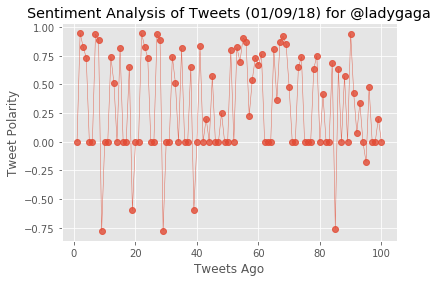

Tweet Successful for User:@ladygaga
tweet length:1
User:@BarackObama Tweet ID: 950923328394379265
file name: Tweet_Sentiments_@BarackObama.png


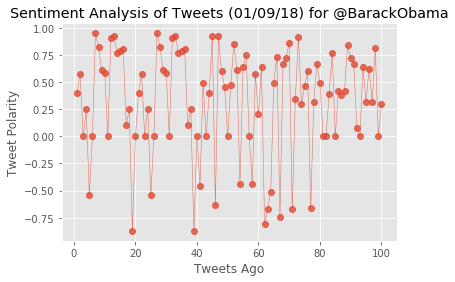

Tweet Successful for User:@BarackObama
tweet length:1
User:@BillGates Tweet ID: 950924588107493376
file name: Tweet_Sentiments_@BillGates.png


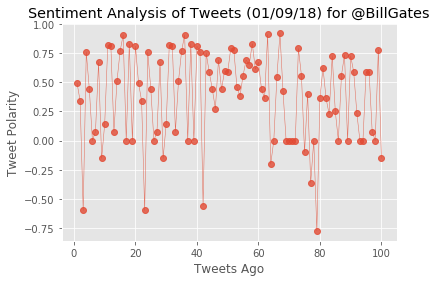

Tweet Successful for User:@BillGates


In [8]:
# Call the function to run the two functions every minute
counter = 0

while(True):
    try:
        user, tweet_id = GetUser()
        if (user != ''):
            CreateAndTweetPlot(user, tweet_id)
        time.sleep(300)
    
        counter += 1
        if counter == 3:
            break
    except tweepy.TweepError as e:
        print("Exception :"+ e.reason)
        break